In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Read in the data matrices of Human PBMC
Profile ASAP-Seq and CITE-Seq before and after T cell stimulation. PBMCs are separated into two groups, one is stimulated with anti-CD3/CD28 and IL-2 for 6h, the other one is the control group. Each group is further splited to run ASAP-Seq and CITE-Seq separately.

In [2]:
dir = '../data/real/ASAP-PBMC/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in range(1,5):
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    try:
        counts_protein = np.array(sp.load_npz(os.path.join(dir, 'PxC' + str(batch) + ".npz")).todense().T)
        counts_protein = utils.preprocess(counts_protein, modality = "RNA")
        
    except:
        counts_protein = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)
    counts_proteins.append(counts_protein)

counts = {"rna":counts_rnas, "atac": counts_atacs, "protein": counts_proteins}

A1 = sp.load_npz(os.path.join(dir, 'GxP.npz'))
A2 = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A1 = np.array(A1.todense())
A2 = np.array(A2.todense())

interacts = {"rna_atac": A2, "rna_protein": A1}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()
proteins = pd.read_csv(dir + "proteins.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions, "protein": proteins}
counts["feats_name"] = feats_name

In [3]:
#hyper parameters
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
Ns = [10] * 4
K = 10
N_feat = Ns[0]
interval = 100
T = 4000
lr = 1e-2

In [4]:
model1 = model.cfrm_new2(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -133.1254
	 loss 1: 166.87428
	 loss 2: 0.00000
	 loss 3: -299.99963
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 200, Validating Loss: -133.6712
	 loss 1: 166.32576
	 loss 2: 0.00000
	 loss 3: -299.99692
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 300, Validating Loss: -140.5279
	 loss 1: 159.44824
	 loss 2: 0.00000
	 loss 3: -299.97610
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 400, Validating Loss: -147.4178
	 loss 1: 152.54437
	 loss 2: 0.00000
	 loss 3: -299.96222
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 500, Validating Loss: -149.5106
	 loss 1: 150.47040
	 loss 2: 0.00000
	 loss 3: -299.98099
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 600, Validating Loss: -150.9557
	 loss 1: 149.03424
	 loss 2: 0.00000
	 loss 3: -299.98996
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 700, Validating Loss: -152.2018
	 loss 1: 147.78587
	 loss 2: 0.00000
	 loss 3: -299.98770
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 800, Validating Loss: -153.0985

In [5]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [6]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

### Ground truth labeling

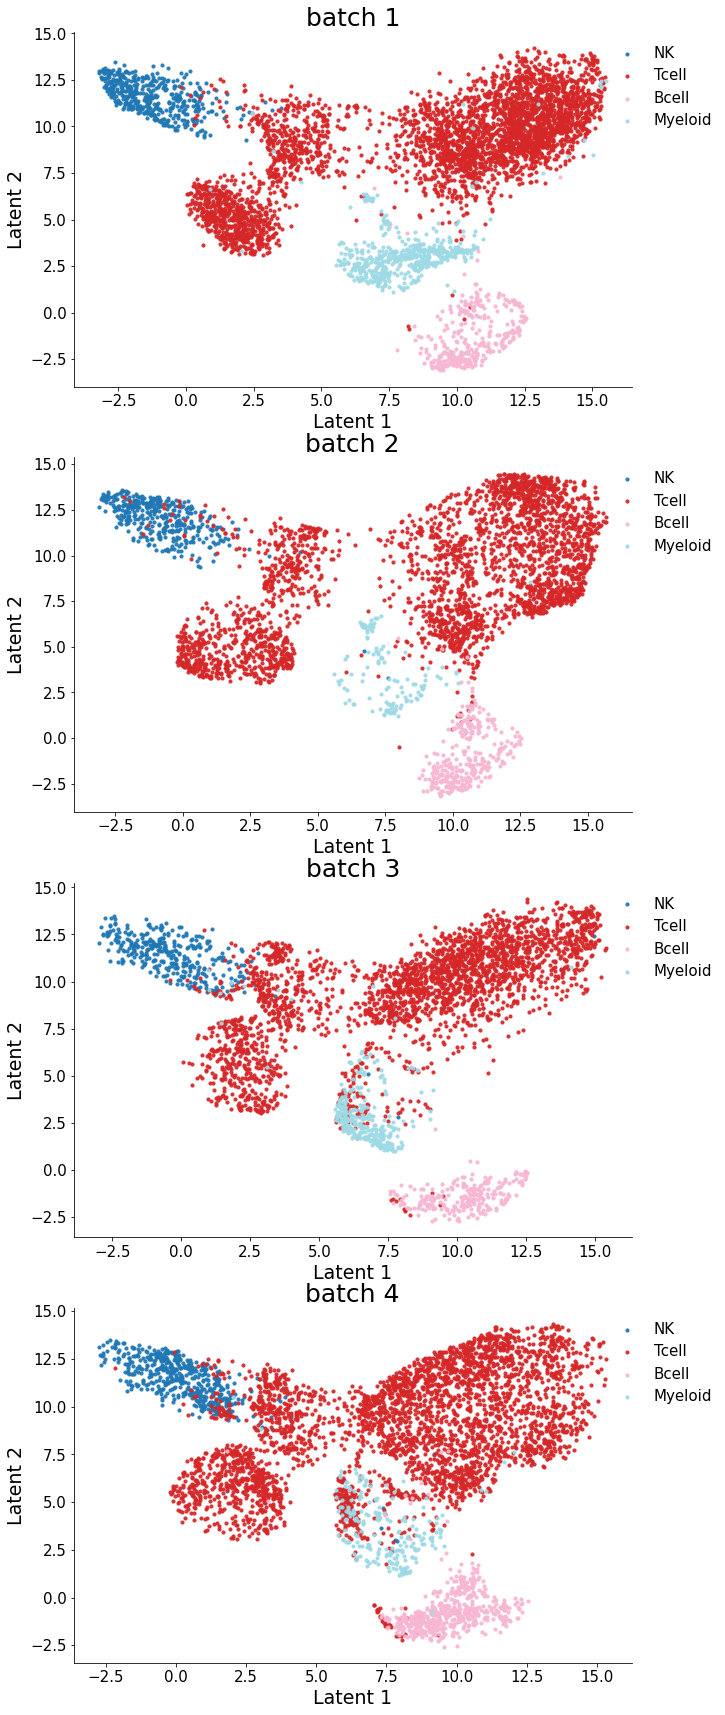

In [7]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")


### Prediction of scJMT

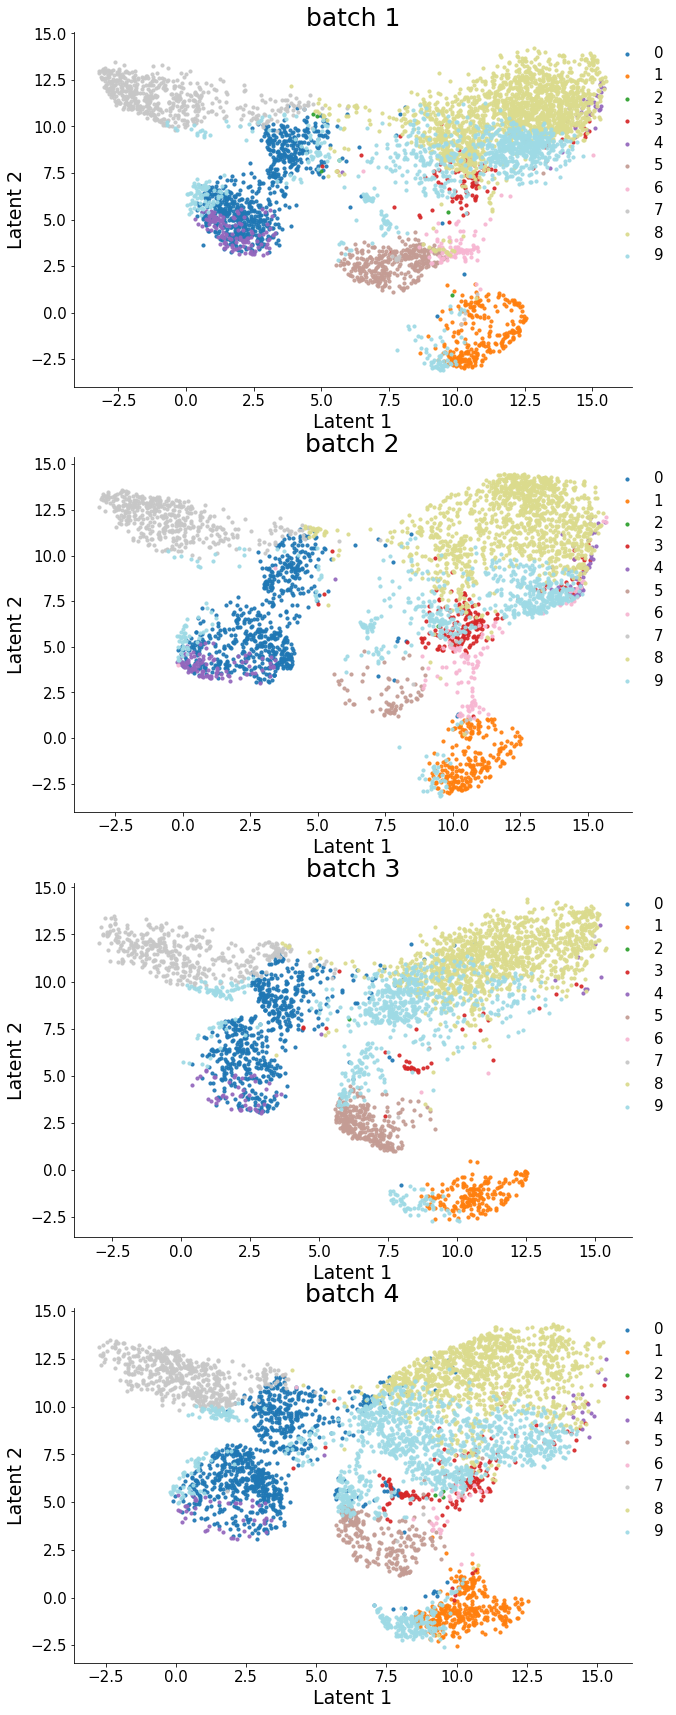

In [8]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")


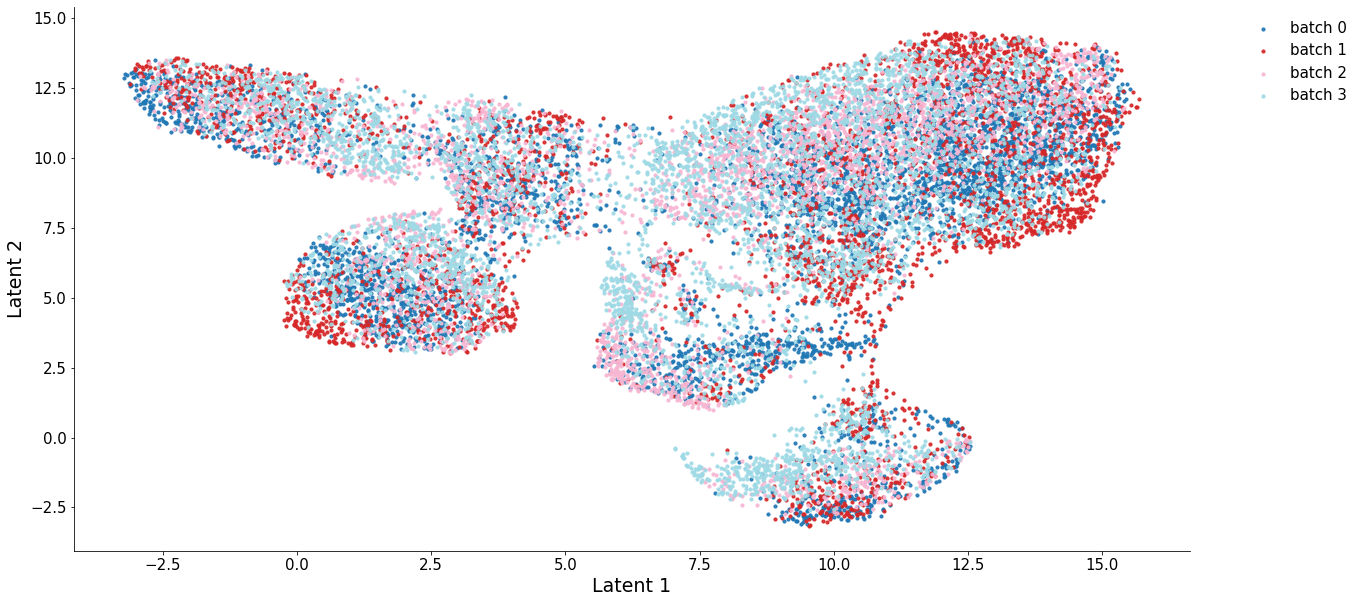

In [9]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


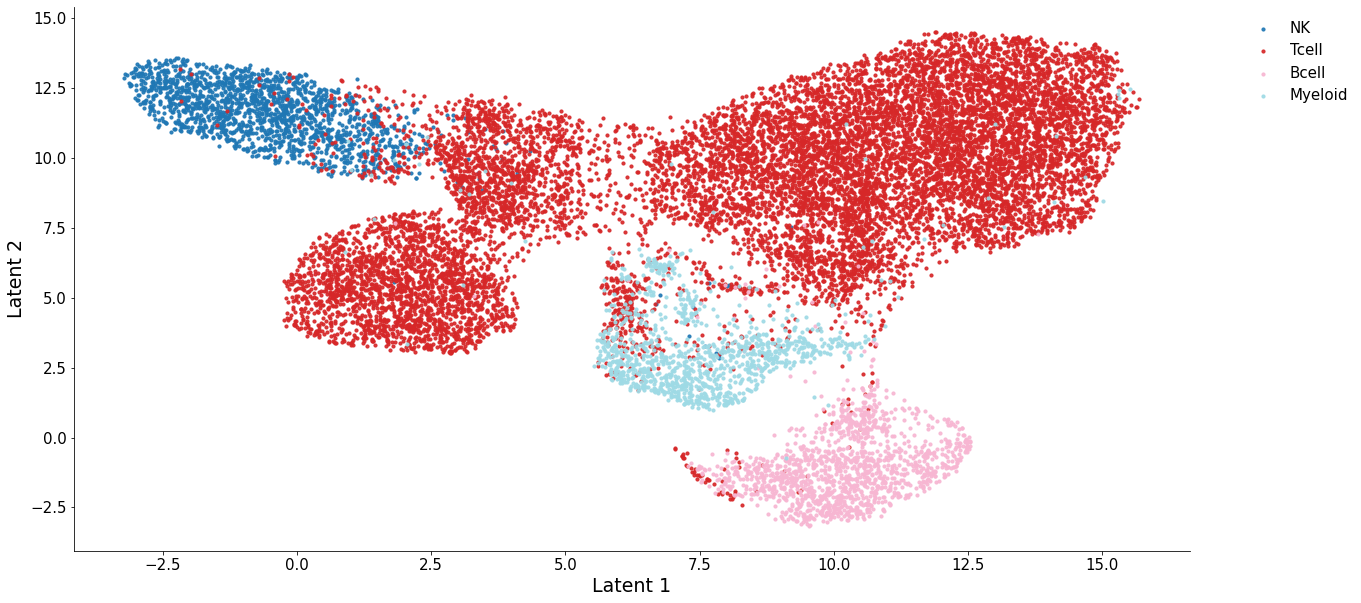

In [10]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


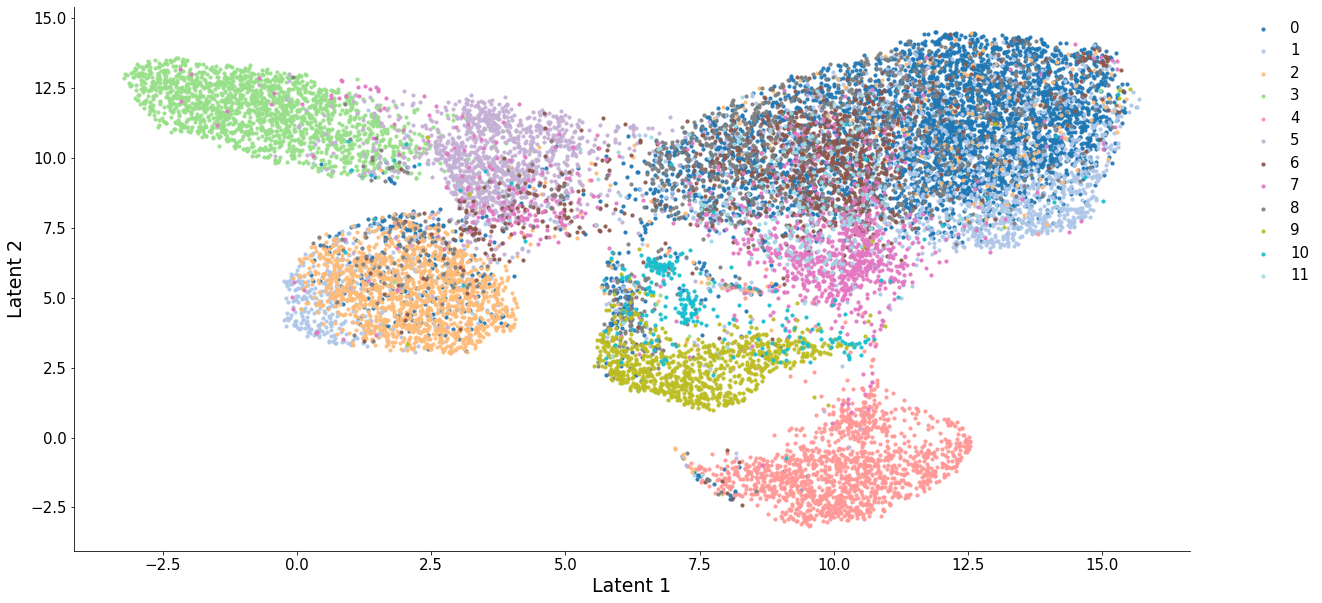

In [11]:
utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


## Post-processing (not necessary in this case)

In [12]:
# Quantile normalization

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

zs2 = quantile.quantile_norm(zs)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

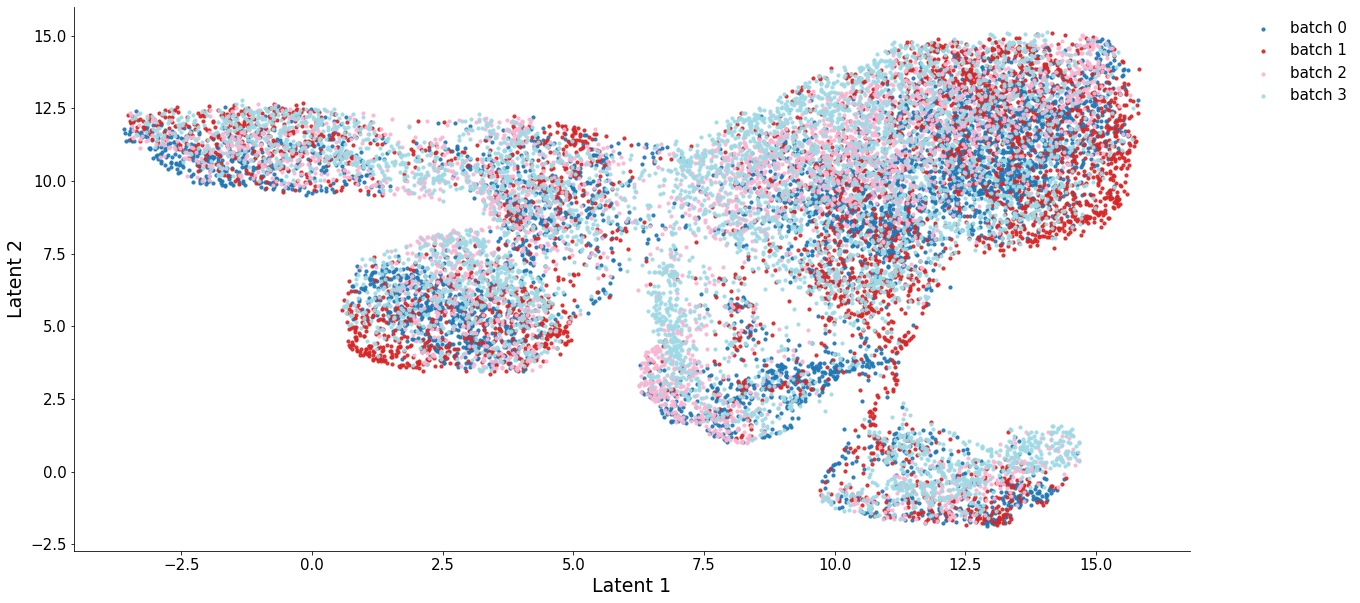

In [13]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


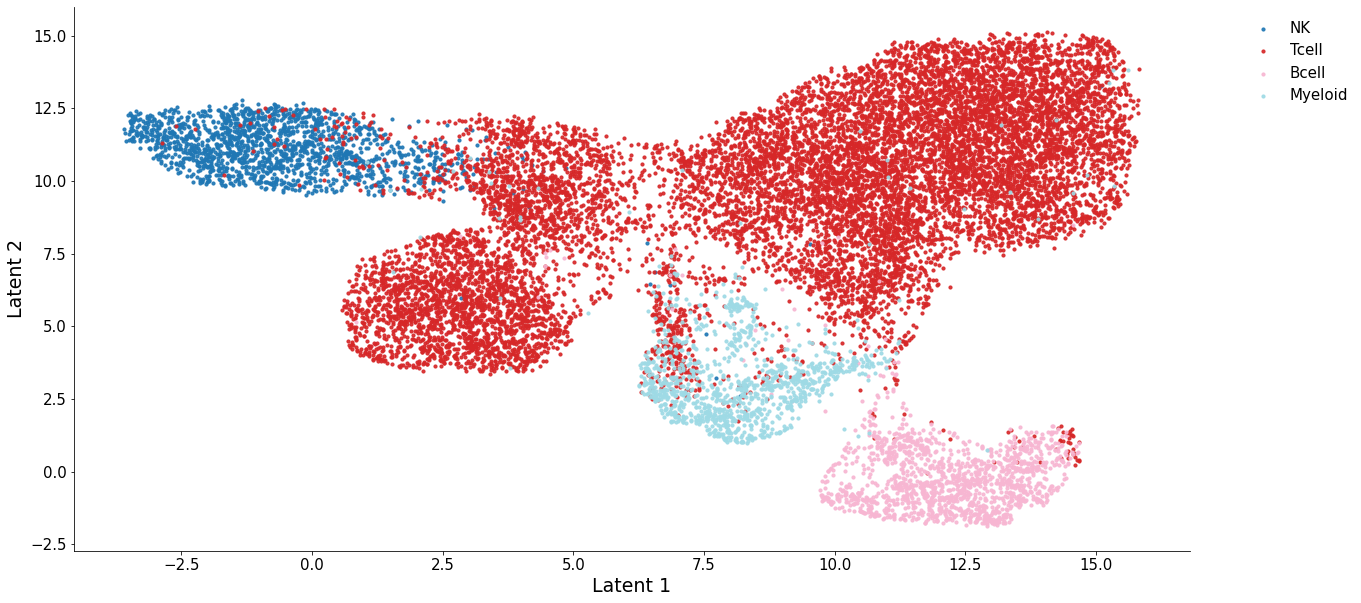

In [14]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


In [15]:
# scDART flavor

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(4):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["coarse_cluster"].values.squeeze())
    prec_labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cluster"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(4):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

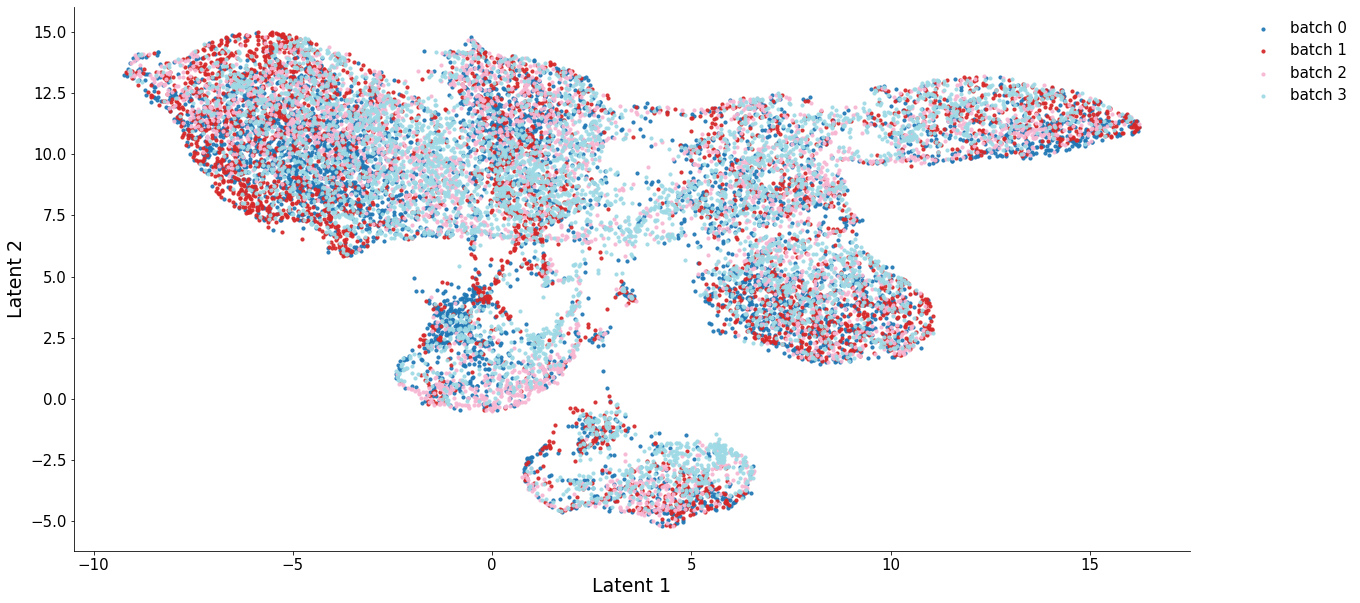

In [16]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


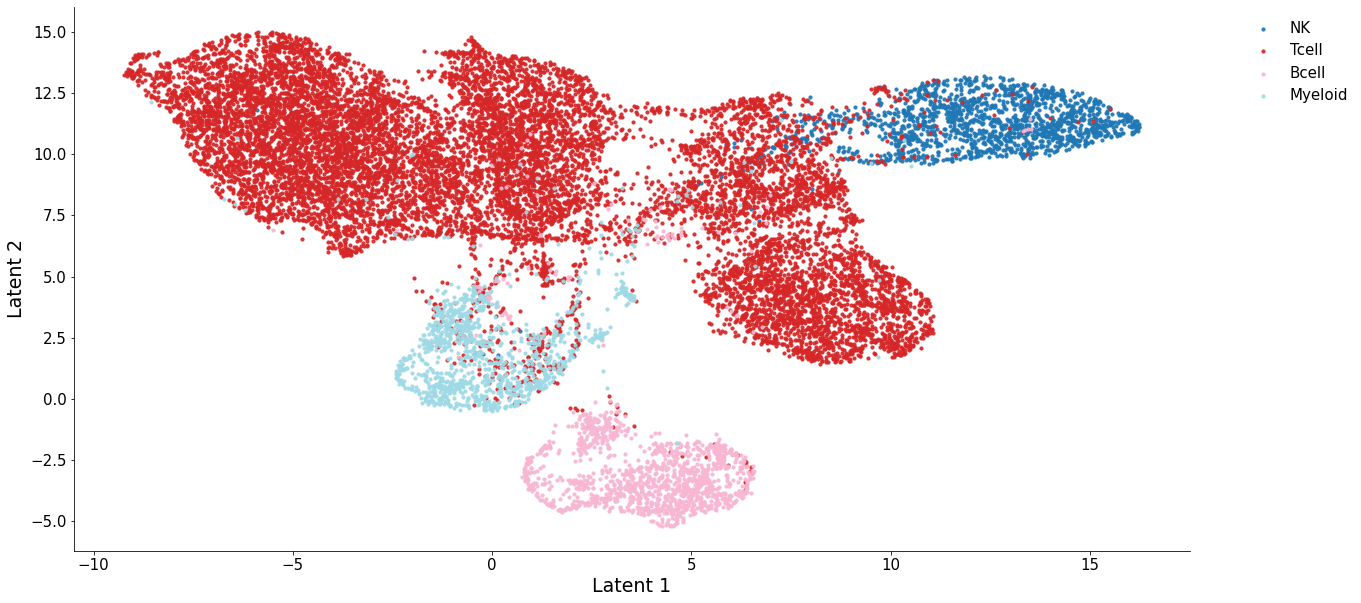

In [17]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


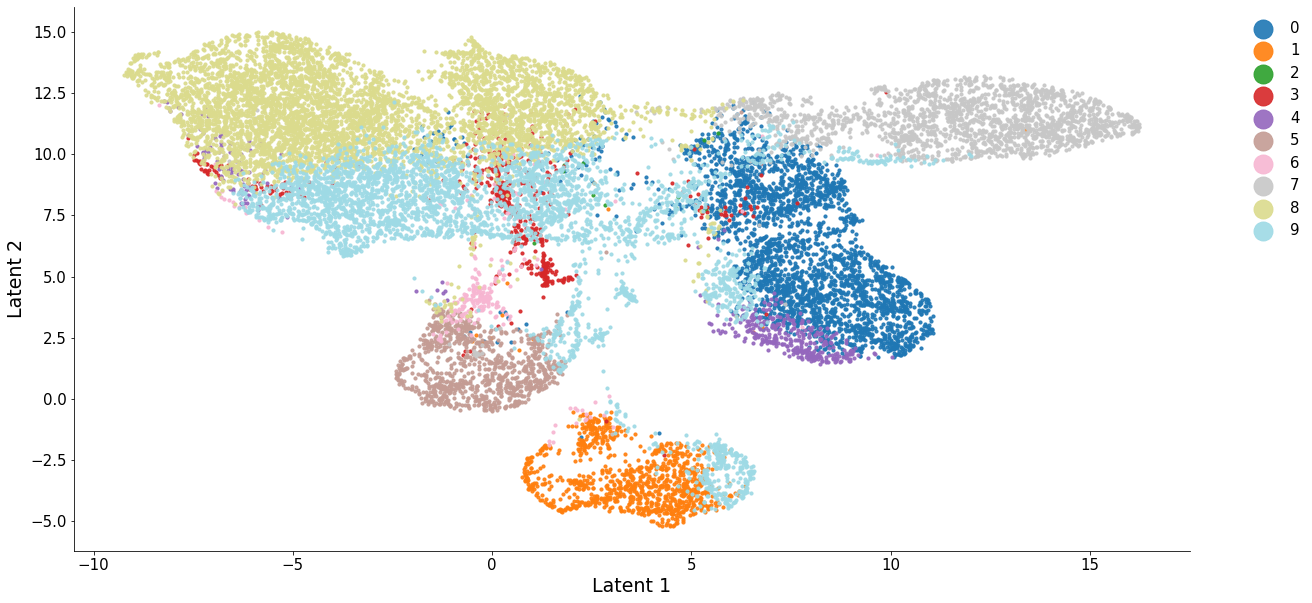

In [18]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = "pancreas/umap_joint_pred.png", 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


## Analyzing the DE genes

Markers for the acinar cell type (factor 7), include `CPA1`(baron paper, Fig. 2a), `REG1A` (https://satijalab.org/seurat/archive/v3.0/integration.html), 

Markers for the beta cell type (factor 8), include `INS` and `IAPP` (baron paper, Fig. 2a) are found in the factor 8.

Markers for the alpha cell type (factor 1, and 3), include `TM4SF4`, `GCG`, `LOLX4`,`IRX2`, `ARX`,`TTR` (A Single-Cell Transcriptome Atlas of the Human Pancreas, abstract, Fig. 1E) is found in factor 1 and factor 3. Difference between factor 1 and factor 3.

Markers for the delta cell type (factor 9, very well mixed with factor 8 beta-cell), not found yet.

Markers for the ductal cell type (factor 5), include `SPP1`, `CFTR`, `MMP7`, `TSPAN8`. (A Single-Cell Transcriptome Atlas of the Human Pancreas, abstract, Fig. S1I)




In [20]:
C_genes = model1.findMarkers(truncate = False)
C_gene = C_genes[0]

In [24]:
n_selected = 100
for mod in range(len(model1.mods)):
    for clust in range(C_gene.shape[1]):
        factor = "factor_" + str(clust)
        factor_values = C_gene.loc[:, [factor]]
        factor_values = factor_values.sort_values(by = factor, ascending = False)[:n_selected]
        if not os.path.exists('PBMC/' + model1.mods[mod] + "_soft"):
            os.makedirs('PBMC/' + model1.mods[mod] + "_soft")
        factor_values.to_csv('PBMC/' + model1.mods[mod] + "_soft/clust_" + str(clust) + ".csv")

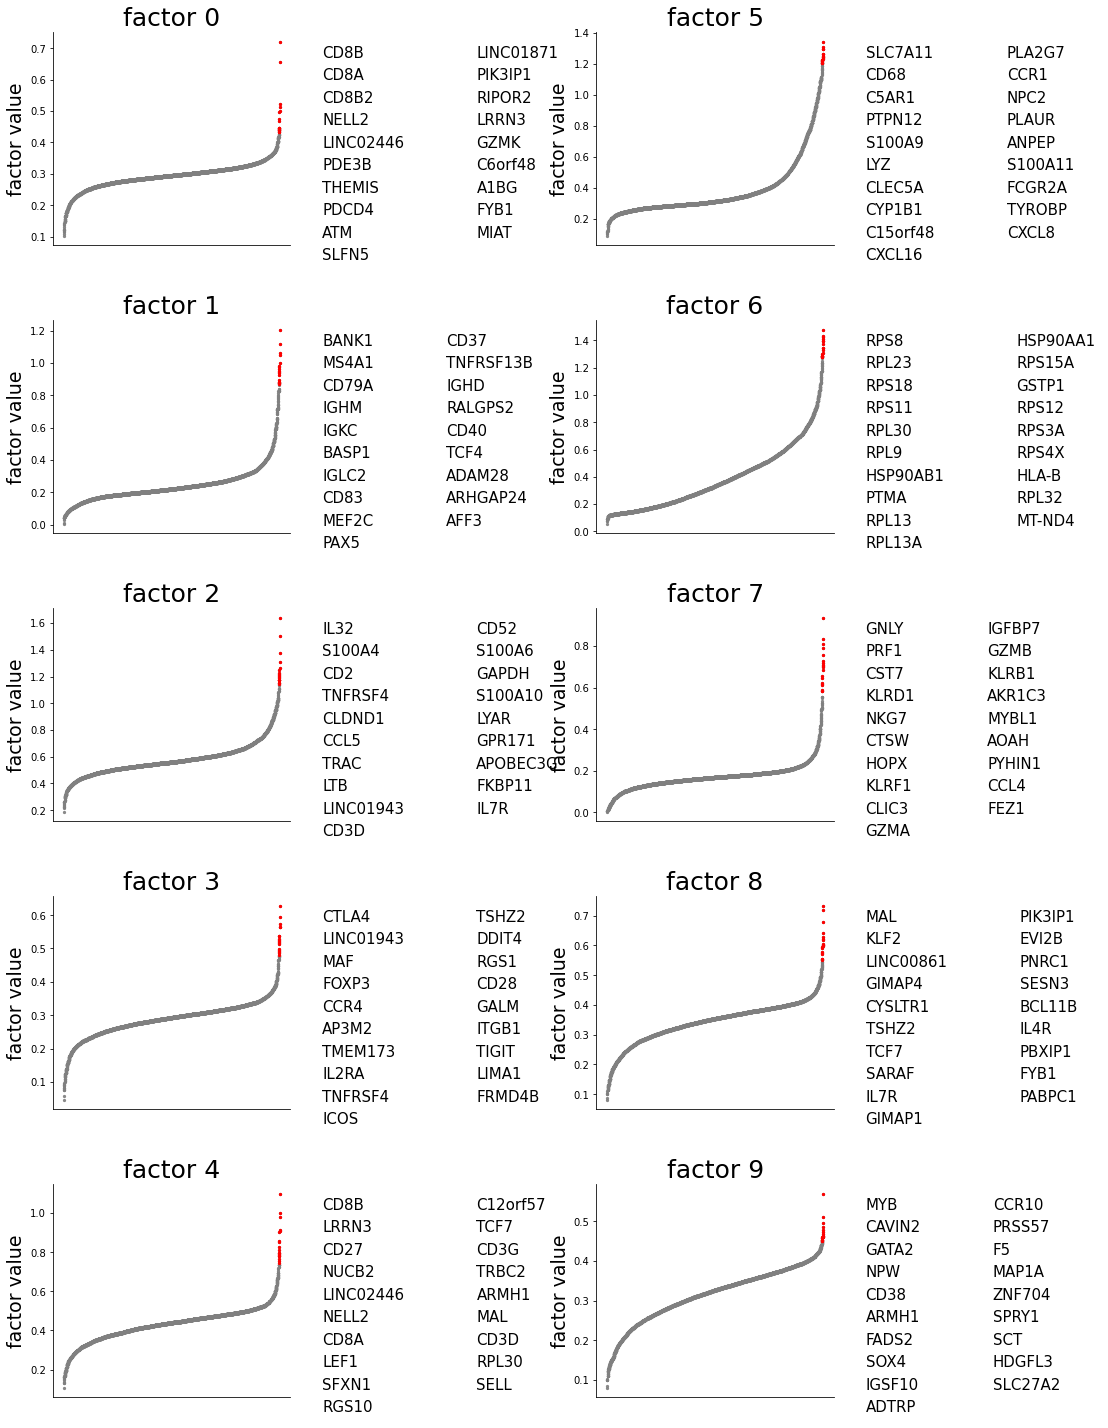

In [26]:
# plot the result from hard method
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,20), save_as = "PBMC/plots/gene_factors_soft.png", title = None)


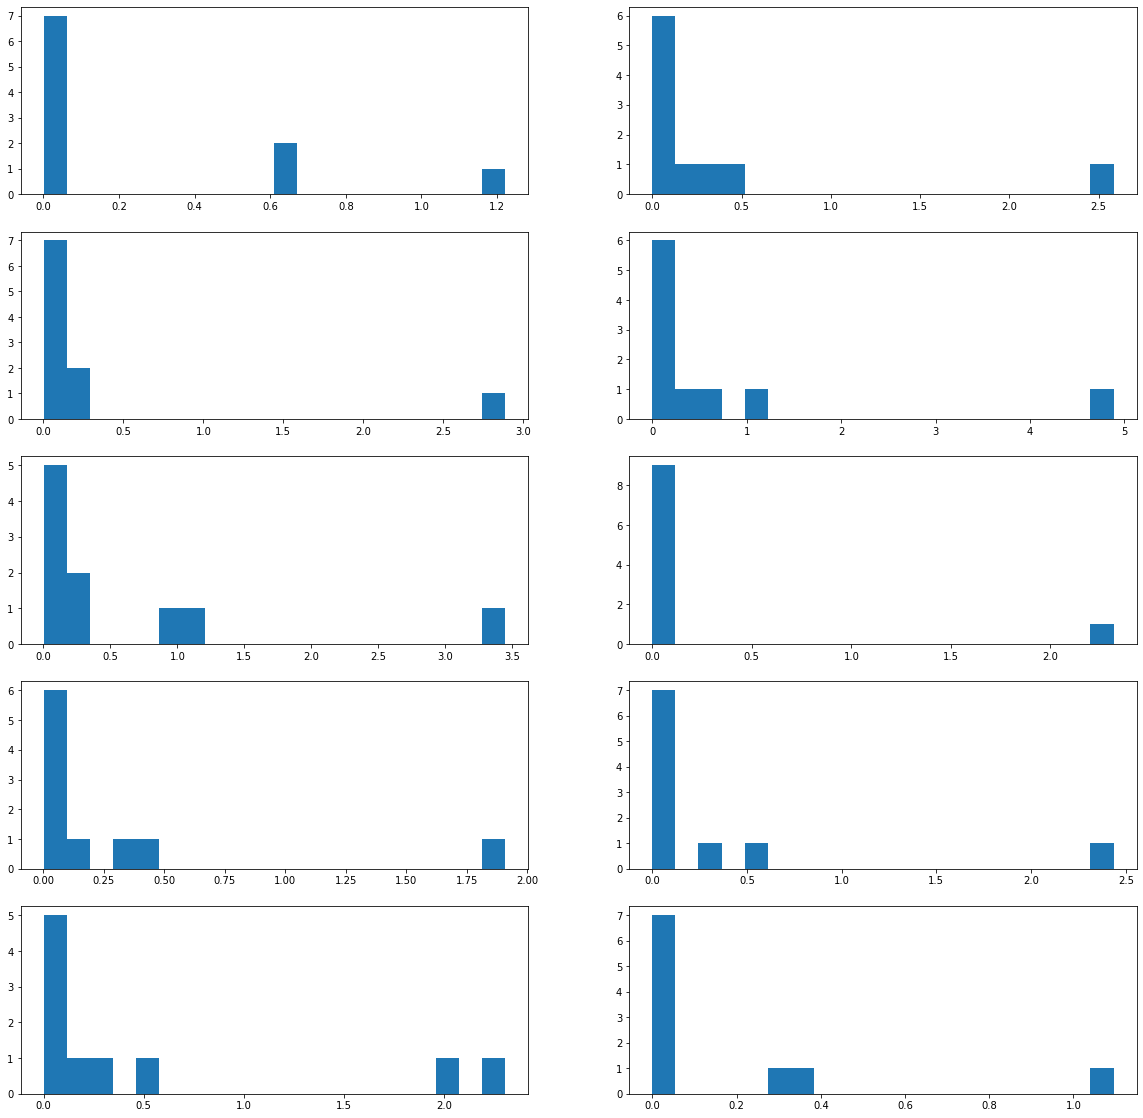

In [11]:
# Assos_score = np.abs(model1.A_assos[0].cpu().numpy())
Assos_score = model1.A_assos[0].cpu().numpy()
nrows = np.ceil(Assos_score.shape[0]/2).astype('int32')
ncols = 2

mod = 0
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(model1.C_feats[mod].shape[1]):
    _ = axs[i%nrows, i//nrows].hist(Assos_score[i,:], bins = 20)
#     axs[i%nrows, i//nrows].set_xlim([0,1])

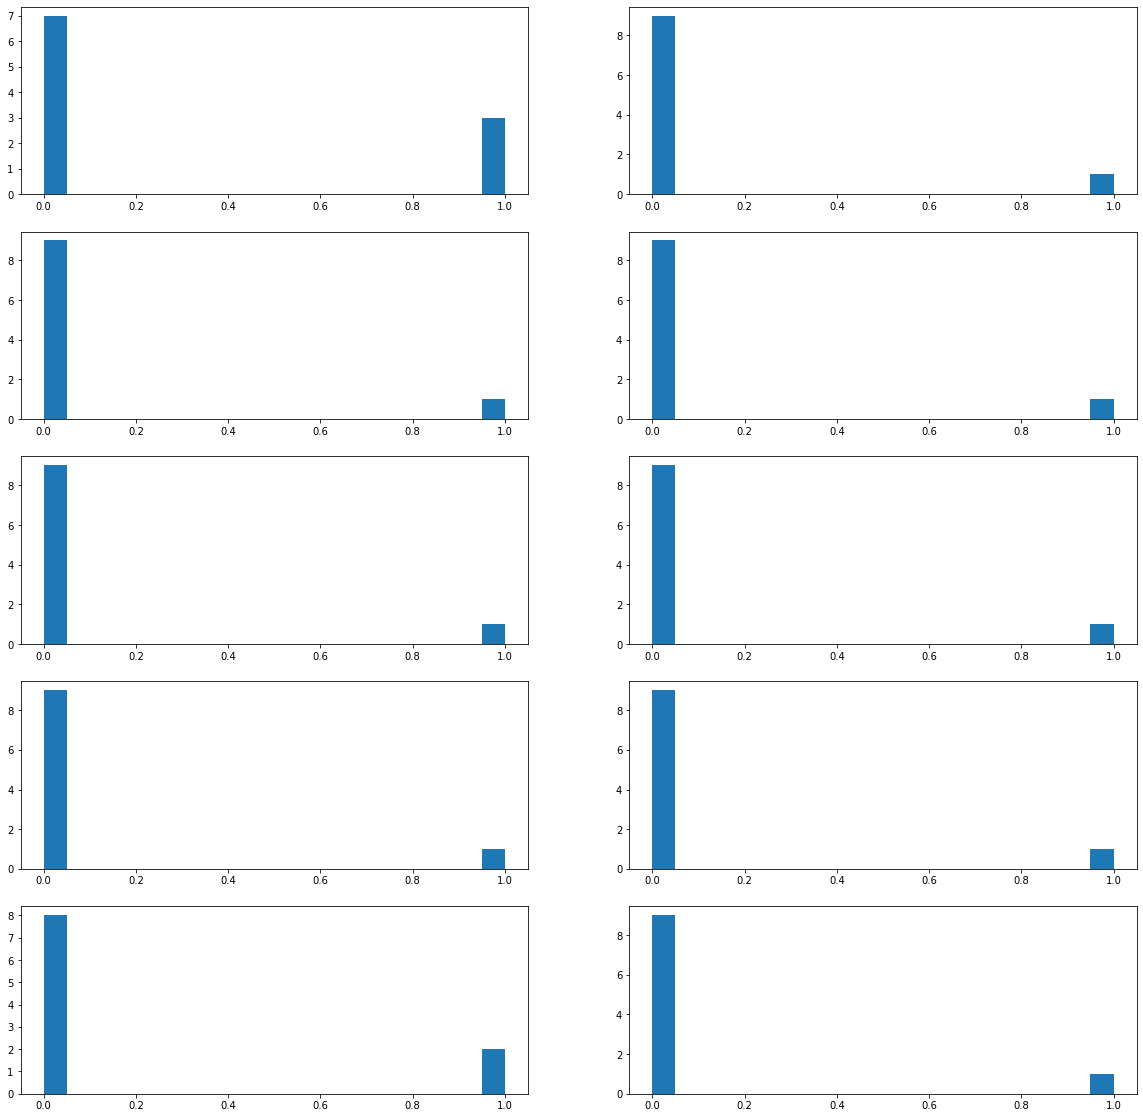

In [12]:
Assos_score = model1.binary_A_assos[0].astype(np.int)
nrows = np.ceil(Assos_score.shape[0]/2).astype('int32')
ncols = 2

mod = 0
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20))

for i in range(model1.C_feats[mod].shape[1]):
    _ = axs[i%nrows, i//nrows].hist(Assos_score[i,:], bins = 20)
#     axs[i%nrows, i//nrows].set_xlim([0,1])

In [14]:
# output de feature list
# for each modalities

de_feats = []
for mod in range(len(model1.binary_A_assos)):
    # create a de list for the current modality
    de_feats.append([])
    
    # extract the Association matrix
    binary_A_asso = model1.binary_A_assos[mod]
    A_asso = model1.A_assos[mod]
    
    # extract the feature factor
    binary_C_feat = model1.binary_C_feats[mod]
    C_feat = model1.C_feats[mod]
    
    # number of cell clusters
    n_clusts = binary_A_asso.shape[0]
    
    for clust in range(n_clusts):
        de_feats[-1].append({})
        # select the feature cluster correspond to each cell cluster
        feat_clusts = np.where(binary_A_asso[clust,:] == True)[0]
        # TODO: Add score metric
        for feat_clust in feat_clusts:
            # select differentially expressed features
            de_feat = [x for x in feats_name[mod][np.where(binary_C_feat[:,feat_clust] == True)[0]]]
            # scoring, consider both Association score and feature factor
            scores = [A_asso[clust, feat_clust].item() * x.item() for x in C_feat[np.where(binary_C_feat[:,feat_clust] == True)[0], feat_clust]]
            for i, feat in enumerate(de_feat):
                if feat in de_feats[-1][-1]:
                    # pass
                    de_feats[-1][-1][feat] += scores[i]
                else:
                    de_feats[-1][-1][feat] =  scores[i]
            
# save the result
for mod, de_feat in enumerate(de_feats):
    if not os.path.exists('PBMC/' + model1.mods[mod]):
        os.makedirs('PBMC/' + model1.mods[mod])
    for clust, de_feat_clust in enumerate(de_feat):
        de_feat_clust_df = pd.DataFrame.from_dict(de_feat_clust, orient = 'index', columns = ["score"]).sort_values(by = ["score"], ascending = False)
        de_feat_clust_df.to_csv('PBMC/' + model1.mods[mod] + "/clust_" + str(clust) + ".csv")

In [63]:
def plot_feat_factor(C_feats, figsize= (20,20), save_as = None, title = None, **kwargs):
    """\
    plot de feat curve

    C_feats:
    ---------
        dataframe of the shape (n_features, n_clusters)
    """
    
    _kwargs = {
        "s": 5,
        "alpha": 0.9,
        "fontsize": 15
    }
    _kwargs.update(kwargs)
    
    n_clusts = C_feats.shape[1]
    
    if n_clusts >= 2:
        nrows = np.ceil(n_clusts/2).astype('int32')
        ncols = 2
    elif n_clusts == 1:
        nrows = 1
        ncols = 1        
        

    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    
    if title:
        fig.suptitle("feature factor loadings", fontsize = 18)


    for clust in range(n_clusts):
        feat_factor = C_feats.iloc[:, clust].values.squeeze()
        # sort the value from the largest to the smallest
        indices = np.argsort(feat_factor)
        
        de_indices = indices[-1:-10:-1]
        
        if nrows != 1:
            axs[clust%nrows, clust//nrows].scatter(np.arange(0, 1, 1/feat_factor.shape[0]), 
                                           feat_factor[indices], color = "gray", alpha = _kwargs["alpha"], s =_kwargs["s"])
            
            for i, de_idx in enumerate(de_indices):
                axs[clust%nrows, clust//nrows].scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                                                       feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                                                       label = C_feats.index.values[de_idx])
                

            axs[clust%nrows, clust//nrows].set_title("factor " + str(clust), fontsize = 25)
            axs[clust%nrows, clust//nrows].set_ylabel("factor value", fontsize = 19)
            axs[clust%nrows, clust//nrows].set_xticks([])
            axs[clust%nrows, clust//nrows].spines['right'].set_visible(False)
            axs[clust%nrows, clust//nrows].spines['top'].set_visible(False)
            leg = axs[clust%nrows, clust//nrows].legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)
          
        elif nrows == 1 and ncols == 1:
           
            axs.scatter(np.arange(0, 1, 1/feat_factor.shape[0]), feat_factor[indices], color = 'gray', alpha = _kwargs["alpha"], s =_kwargs["s"])

            for i, de_idx in enumerate(de_indices):
                axs.scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                            feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                            label = C_feats.index.values[de_idx])
                
            axs.set_title("factor " + str(clust), fontsize = 25)
            axs.set_ylabel("factor value", fontsize = 19)
            axs.set_xticks([])
            axs.spines['right'].set_visible(False)
            axs.spines['top'].set_visible(False)
            leg = axs.legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)

        else:
            axs[clust].scatter(np.arange(0, 1, 1/feat_factor.shape[0]), feat_factor[indices], color = 'gray', alpha = _kwargs["alpha"], s =_kwargs["s"])

            for i, de_idx in enumerate(de_indices):
                axs[clust].scatter(np.arange(0, 1, 1/feat_factor.shape[0])[-i -1], 
                                   feat_factor[de_idx], c = "red", s = _kwargs["s"], 
                                   label = C_feats.index.values[de_idx])
                
            axs[clust].set_title("factor " + str(i), fontsize = 25)
            axs[clust].set_ylabel("factor value", fontsize = 19)
            axs[clust].set_xticks([])
            axs[clust].spines['right'].set_visible(False)
            axs[clust].spines['top'].set_visible(False)
            leg = axs[clust].legend(bbox_to_anchor=(0.9,1), loc="upper left", fontsize = _kwargs["fontsize"], frameon=False)
            for item in leg.legendHandles:
                item.set_visible(False)
 
    fig.tight_layout(pad=0.0)
    if save_as!= None:
        fig.savefig(save_as, bbox_inches = 'tight')
    
    plt.show()     

In [69]:
# Just factor loading, model1.C_feats[2] is the protein
C_protein = model1.softmax(model1.C_feats[2]).data.cpu().numpy()
C_protein = pd.DataFrame(data = C_protein, index = proteins, columns = ["factor_" + str(i) for i in range(C_protein.shape[1])])
plot_feat_factor(C_protein, figsize = (10,20), save_as = None, title = None)


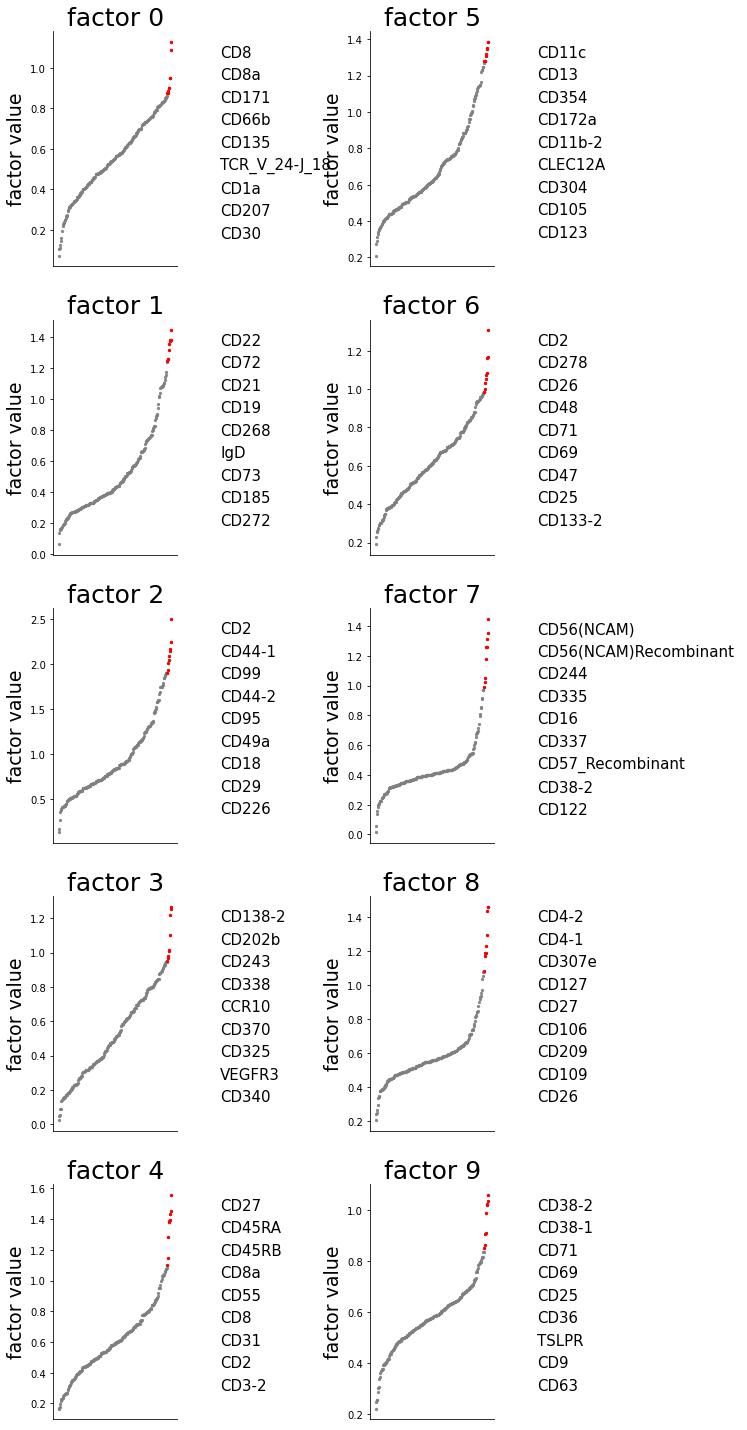

In [68]:
# Factor loading with association matrix, more like the de features
C_protein = model1.softmax(model1.C_feats[2]).data.cpu().numpy() @ model1.A_assos[2].data.cpu().numpy().T
C_protein = pd.DataFrame(data = C_protein, index = proteins, columns = ["factor_" + str(i) for i in range(C_protein.shape[1])])
plot_feat_factor(C_protein, figsize= (10,20), save_as = None, title = None)


## Infer cross modalities relationship

In [9]:
# RNA & ATAC
RNA_ATAC = utils.infer_interaction(model1.C_feats[0].data.cpu().numpy(), model1.C_feats[1].data.cpu().numpy())

# RNA & Protein
RNA_PROTEIN = utils.infer_interaction(model1.C_feats[0].data.cpu().numpy(), model1.C_feats[2].data.cpu().numpy())

# Protein & ATAC
PROTEIN_ATAC = utils.infer_interaction(model1.C_feats[2].data.cpu().numpy(), model1.C_feats[1].data.cpu().numpy())

In [10]:
import pandas as pd
import numpy as np

from sklearn.metrics import precision_recall_curve, roc_curve, auc
from itertools import product, permutations, combinations, combinations_with_replacement

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay,roc_curve,auc,RocCurveDisplay, average_precision_score, roc_auc_score


def compute_auc(estm_adj, gt_adj, directed = False):
    """\
    Description:
    ------------
        calculate AUPRC and AUROC
    Parameters:
    ------------
        estm_adj: predict graph adjacency matrix
        gt_adj: ground truth graph adjacency matrix
        directed: the directed estimation or not
    Return:
    ------------
        prec: precision
        recall: recall
        fpr: false positive rate
        tpr: true positive rate
        AUPRC, AUROC
    """
    estm_norm_adj = np.abs(estm_adj)/np.max(np.abs(estm_adj) + 1e-12)
    
    if np.max(estm_norm_adj) == 0:
        return 0, 0, 0, 0, 0, 0
    else:
        # assert np.abs(np.max(estm_norm_adj) - 1) < 1e-4
        if directed == False:
            gt_adj = ((gt_adj + gt_adj.T) > 0).astype(np.int)
        np.fill_diagonal(gt_adj, 0)
        np.fill_diagonal(estm_norm_adj, 0)
        rows, cols = np.where(gt_adj != 0)

        fpr, tpr, thresholds = roc_curve(y_true=gt_adj.reshape(-1,), y_score=estm_norm_adj.reshape(-1,), pos_label=1)
        prec, recall, thresholds = precision_recall_curve(y_true=gt_adj.reshape(-1,), probas_pred=estm_norm_adj.reshape(-1,), pos_label=1)

        # the same
        # AUPRC = average_precision_score(gt_adj.reshape(-1,), estm_norm_adj.reshape(-1,)) 

        return prec, recall, fpr, tpr, auc(recall, prec), auc(fpr, tpr)

In [14]:
# AUPRC
*_, AUPRC_rna_atac, AUROC_rna_atac = compute_auc(RNA_ATAC, interacts["rna_atac"], directed = True)
*_, AUPRC_rna_protein, AUROC_rna_protein = compute_auc(RNA_PROTEIN, interacts["rna_protein"], directed = True)

RNA_ATAC_rand = np.random.rand(RNA_ATAC.shape[0], RNA_ATAC.shape[1])
RNA_PROTEIN_rand = np.random.rand(RNA_PROTEIN.shape[0], RNA_PROTEIN.shape[1])

*_, AUPRC_rna_atac_rand, AUROC_rna_atac_rand = compute_auc(RNA_ATAC_rand, interacts["rna_atac"], directed = True)
*_, AUPRC_rna_protein_rand, AUROC_rna_protein_rand = compute_auc(RNA_PROTEIN_rand, interacts["rna_protein"], directed = True)

AUPRC_rna_atac_ratio = AUPRC_rna_atac/AUPRC_rna_atac_rand
AUPRC_rna_protein_ratio = AUPRC_rna_protein/AUPRC_rna_protein_rand

print("AUPRC (RNA & ATAC): {:.3f}".format(AUPRC_rna_atac_ratio))
print("AUPRC (RNA & protein): {:.3f}".format(AUPRC_rna_protein_ratio))


AUPRC (RNA & ATAC): 0.930
AUPRC (RNA & protein): 3.702
